In [22]:
import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges, county_splits
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap

import pandas as pd

In [16]:
gn = 2
k = 2
ns = 75
p = 0.5

graph = nx.grid_graph([k * gn, k * gn])


for n in graph.nodes():
    graph.node[n]["population"] = 1

    if random.random() < p:
        graph.node[n]["pink"] = 1
        graph.node[n]["purple"] = 0
    else:
        graph.node[n]["pink"] = 0
        graph.node[n]["purple"] = 1
    if 0 in n or k * gn - 1 in n:
        graph.node[n]["boundary_node"] = True
        graph.node[n]["boundary_perim"] = 1

    else:
        graph.node[n]["boundary_node"] = False


In [17]:
for n in range(4):
    for m in range(2):
        graph.node[(n,m)]['county'] = 0
    for m in [2,3]:
        graph.node[(n,m)]['county'] = 1

In [18]:
cddict = {x: int(x[0] / gn) for x in graph.nodes()}

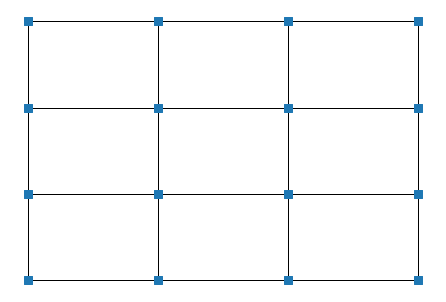

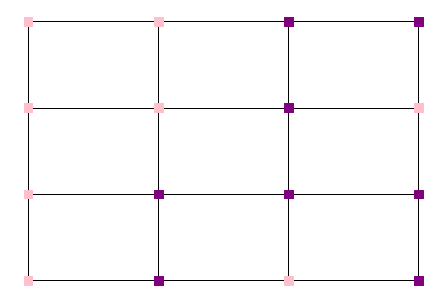

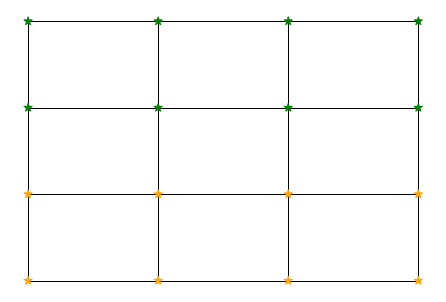

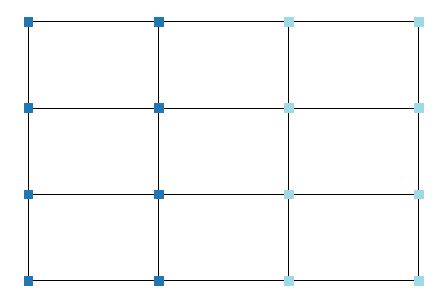

In [19]:
plt.figure()
nx.draw(graph, pos={x: x for x in graph.nodes()}, node_size=ns, node_shape="s")
plt.show()

cdict = {1: "pink", 0: "purple"}

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cdict[graph.node[x]["pink"]] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
)
plt.show()

countycolor = {1: 'green', 0: 'orange'}
plt.figure()
nx.draw(graph, 
        pos={x: x for x in graph.nodes()}, 
        node_color = [countycolor[graph.node[x]['county']] for x in graph.nodes()],
        node_size = ns,
        node_shape = '*'
       )
plt.show()

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cddict[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)
plt.show()

In [20]:
def step_num(partition):
    parent = partition.parent
    if not parent:
        return 0
    return parent["step_num"] + 1


updaters = {
    "population": Tally("population"),
    "cut_edges": cut_edges,
    "step_num": step_num,
    "Pink-Purple": Election("Pink-Purple", {"Pink": "pink", "Purple": "purple"}),
}

In [21]:
grid_partition = Partition(graph, assignment=cddict, updaters=updaters)

In [29]:
data = []
for i in range(16):
    data.append([])
nodes = []
for m in range(4):
    for n in range(4):
        nodes.append((m,n))
for i in range(16):
    data[i].append(nodes[i])
    data[i].append(graph.node[data[i][0]]['pink'])
    data[i].append(graph.node[data[i][0]]['purple'])
    data[i].append(graph.node[data[i][0]]['county'])
    
columns = ['node', 'pink', 'purple', 'county']

In [31]:
df = pd.DataFrame(data, columns = columns)

In [36]:
county_field_name = 'county'
unique_label = 'node'
def num_splits(partition, df=df, level = county_field_name):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby(level)["current"].nunique() > 1)
    return splits
#splits_constraint = SelfConfiguringUpperBound(num_splits)

In [37]:
num_splits(grid_partition)

2